<a href="https://colab.research.google.com/github/Samuy93/aid2_proyecto_nlp/blob/main/Proyecto_final_AID2_2020_RNN_BATCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Final AID2 2020
El proyecto se basa en el Data Challenge 2019, Mercado Libre
Nombre: Samuel Astol

In [68]:
# Natural Language Tool Kit
!pip install nltk
!pip install requests
!pip install pandas
!pip install DataLoader
!pip install torch

In [69]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [70]:
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string
import requests
import gzip
import shutil
import pandas as pd
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Descarga y Carga del Dataset

In [71]:
# Downlad files
def download_file(url, destination):
    session = requests.Session()
    response = session.get(url, stream = True)
    save_response_content(response, destination)
def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
download_file("https://meli-data-challenge.s3.amazonaws.com/train.csv.gz" , 'dataset.gz')
download_file("https://meli-data-challenge.s3.amazonaws.com/test.csv" , 'datasetTest.csv')

In [72]:
# read gz file
dataset_train = None
with gzip.open('dataset.gz') as f:
    dataset_train = pd.read_csv(f)

# Definir entorno de ejecucion 

In [73]:
is_developer_mode = True
max_groups_evaluation = 3

In [74]:
def is_group_iteration_topped(index):
  return is_developer_mode and  index >= max_groups_evaluation

# Definir Pre-Procesamiento del Dataset

En esta etapa se procede a normalizar el dataset

* removemos elementos vacios
* removemos signos de puntuacion
* removemos stopwords (espano y portugues)

Notas: 
* se considera todo el dataset como un solo lenguaje, para el caso de estudio pero se entiende que a la hora de predecir los resultados en español o portugues pueda tener una considerable preferencia a a predecir correcto en uno de los lenguajes.
* para el proposito del proyecto se tomo por clase un total de samples igual al minimo encontrado en todas las classes.




In [75]:
# tokenize and remove stopwords from str list
class Custom_Str_Sanitizer:
  def remove_punctuation(self, text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

  def remove_stop_words(self, titles, language):
    stop_words = set(stopwords.words(language.lower()))
    return [w for w in titles if w not in stop_words]

  def sanitize_dataset(self, titles, language):
    to_return = []
    for title in titles:
      title = self.remove_stop_words([word.lower() for word in word_tokenize(self.remove_punctuation(title))], language)
      title = [word for word in title if word.isalpha()]
      to_return.append(title)
    return toReturn

  def start(self, titles, language):
    return self.sanitize_dataset(titles, language)

In [76]:
# tokenize and remove stopwords
class Custom_Sanitizer:
  def remove_punctuation(self, text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

  def remove_top_words(self, lst, language):
    stop_words = set(stopwords.words(language.lower()))
    return [w for w in lst if w not in stop_words]

  def sanitize_dataset(self, df):
    corpus = []
    newDf = df.copy(deep=True)
    for index, row in newDf.iterrows():
      row.title = self.remove_top_words([word.lower() for word in word_tokenize(self.remove_punctuation(row.title))], row.language)
      #row.title = [word for word in row.title if word.isalpha()]
      corpus.append(row.title)
    return newDf, corpus

  def start(self, df):
    return self.sanitize_dataset(df)

# Definicinon del Vocabulario

In [77]:
class Vocabulary:
  def __init__(self, corpus):
    self.corpus = corpus
    self.vect_corpus = []
    self.vocab = []

  def built(self):
    for doc in self.corpus:
      self.add_doc(doc)

  def add_doc(self, doc):
    vocab_set = set(self.vocab)
    doc_set = set(doc)
    diff = doc_set.difference(vocab_set)
    new_tokens = [token for token in doc if token in diff]
    self.vocab = self.vocab + new_tokens
    self.vect_corpus.append([self.get_index_of_token(token) for token in doc])

  def get_token_by_index(self, index):
    return self.vocab[index]

  def get_index_of_token(self, token):
    return self.vocab.index(token)
      

In [78]:
class Data_Set:
  def remove_rows_with_empty_col(self, colName):
    self.df[colName].replace('', np.nan, inplace=True)
    self.df.dropna(subset=[colName], inplace=True)

  def calculate_min_and_avg_group(self, dt):
    category_row_size = []
    minVal = -1;
    print("Num of groups: %s" % len(dt.groups))
    group_index = 0
    for category in dt.groups:
      if is_group_iteration_topped(group_index):
        break
      group = dt.get_group(category)
      rows, cols = group.shape
      category_row_size.append(rows)
      if minVal == -1:
        minVal = rows
      elif minVal > rows:
        minVal = rows
      group_index = group_index + 1
      
    min_rows_per_category = min(category_row_size)
    avg_rows_per_category = sum(category_row_size)/len(category_row_size)
    print("Min num of rows in categories: %s" % min_rows_per_category)
    print("Avg num of rows in categories: %s" % avg_rows_per_category)
    return min_rows_per_category, avg_rows_per_category

  def set_even_rows_per_group(self, df, min):
    toReturn = pd.DataFrame(columns=["title","label_quality","language","category"])
    group_index = 0
    for category in df.groups:
      if is_group_iteration_topped(group_index):
        break
      group = df.get_group(category).take(range(min))
      toReturn = toReturn.append(group, ignore_index=True)
      group_index = group_index + 1
    return toReturn

  def transform(self, df):
    self.df = df
    self.remove_rows_with_empty_col('title')
    self.remove_rows_with_empty_col('category')
    by_categories = self.df.groupby(by='category', as_index=True)
    min_rows_per_category, avgRowsavg_rows_per_categoryPerCategory = self.calculate_min_and_avg_group(by_categories)
    newdf = self.set_even_rows_per_group(by_categories, min_rows_per_category)
    sanitazer = Custom_Sanitizer()
    df_sanitized, corpus = sanitazer.start(newdf)
    all_categories = list(by_categories.groups)[:max_groups_evaluation] if is_developer_mode else list(by_categories.groups)
    mapping_categories = df_sanitized['category']
    return df_sanitized, corpus, all_categories, mapping_categories
      

# Modelo RNN + Word Embedding


In [79]:
# many to one
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)

  def init_weights(self):
    initrange = 0.5
    self.i2o.weight.data.uniform_(-initrange, initrange)
    self.i2o.bias.data.zero_()
    self.i2h.weight.data.uniform_(-initrange, initrange)
    self.i2h.bias.data.zero_()

# Parametros de entrenamiento

*   Ejecucion de pre-procesamiento
*   Armado del vocabulario
*   Sete de Parametros de entrenamieto
*   Padding de los vectores 



In [80]:
# sanitaze corpus (remove stop words, convert to lowercase, same documents per label)
ds = Data_Set()
df_sanitized, corpus, all_categories, mapping_categories = ds.transform(dataset_train)

Num of groups: 1588
Min num of rows in categories: 507
Avg num of rows in categories: 4779.0


In [81]:
# built corpus vector
vocab = Vocabulary(corpus)
vocab.built()

In [82]:
# add padding to all docs, make all docs same len
max_len_vect_doc = max([len(vect_doc) for vect_doc in vocab.vect_corpus])
vect_corpus_padded = np.array([np.pad(vect_doc, (0, max_len_vect_doc - len(vect_doc)), 'constant', constant_values=0) for vect_doc in vocab.vect_corpus])


In [83]:
trains_x, tests_x, trains_y, tests_y = model_selection.train_test_split(vect_corpus_padded, mapping_categories, test_size=0.3)


In [84]:
input_size = len(vect_corpus_padded[0])
embedding_dim = 100
hidden_size = 100
learning_rate = 0.05
n_iters = 1000
plot_steps, print_steps = 100, 100
output_size = len(all_categories)


In [85]:
embedding = nn.Embedding(len(vocab.vocab), embedding_dim, sparse=True)
rnn = RNN(input_size * embedding_dim, hidden_size, output_size)

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)
def train(embedded_document, class_tensor):
  hidden = rnn.init_hidden()
  output, hidden = rnn(embedded_document.view(1,-1), hidden)
  loss = criterion(output, class_tensor)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return output, loss.item()

In [87]:
current_loss = 0
all_losses = []
rnn.init_weights()
embedding.weight.data.uniform_(-0.5, 0.5)
trains_y = list(trains_y)
tests_y = list(tests_y)
for i in range(n_iters):
  for index, doc_padded in enumerate(trains_x):
    embedded_document = embedding(torch.tensor(doc_padded))
    class_tensor = []
    class_index = all_categories.index(trains_y[index])
    class_tensor.append(class_index)
    output, loss = train(torch.flatten(embedded_document), torch.tensor(class_tensor))
    current_loss = current_loss + loss

  if (i+1) % plot_steps == 0:
    print(current_loss / plot_steps)
    all_losses.append(current_loss / plot_steps)
    current_loss = 0

635.0471307039261
609.286866363287
607.8759857809544
606.7578011113405
606.014638223648
605.1961830806732
604.4779571455717
604.4233316588402
603.6458904361725
603.4837563347817


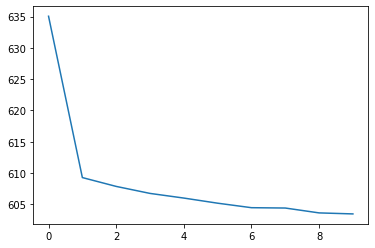

In [92]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)
plt.show()

# Prueba de Predicciones

Nota: se uso el mismo data set de entrenamiendo por temas de timepo

1.   Elemento de lista
2.   Elemento de lista



In [93]:
def predict():
  test_hat_index_y = []
  test_index_y = []
  with torch.no_grad():

    hidden = rnn.init_hidden()
    aciertos = 0
    no_aciertos = 0

    for index, test_x in enumerate(tests_x):
      embedded_document = embedding(torch.tensor(test_x))
      output, hidden = rnn(torch.flatten(embedded_document).view(1,-1), hidden)
      test_hat_index_y.append(torch.argmax(output).item())
      test_index_y.append(all_categories.index(tests_y[index]))
      if tests_y[index] == all_categories[torch.argmax(output).item()]:
        aciertos += 1
      else :
        no_aciertos += 1

    print('num aciertos')
    print(aciertos)
    print('num no aciertos')
    print(no_aciertos)

    return test_index_y, test_hat_index_y

In [94]:
test_index_y, test_hat_index_y = predict()

num aciertos
161
num no aciertos
296


In [95]:
accuracy = accuracy_score(test_index_y, test_hat_index_y)
print('Accuracy: %f' % accuracy)

Accuracy: 0.352298


In [99]:
# precision tp / (tp + fp)
precision = precision_score(test_index_y, test_hat_index_y, average='micro')
print('Precision: %f' % precision)


Precision: 0.352298


In [100]:
# recall: tp / (tp + fn)
recall = recall_score(test_index_y, test_hat_index_y, average='micro')
print('Recall: %f' % recall)


Recall: 0.352298


In [102]:
# formula
2 * (precision * recall) / (precision + recall)

0.3522975929978118

In [101]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_index_y, test_hat_index_y, average='micro')
print('F1 score: %f' % f1)

F1 score: 0.352298


# Conclusion

Apesar de no llegar a una un training completo del dataset, queda seguir refinando la normalizacion del dataset y el ajuste de parametros, a pesar de que se usan solo 3 classes para clasificar obtenemos una precision baja, que no solo sea dado por lo mencionado previamente sino a ah como se esta haciendo el padding en de los doc, en la version actual se ve que se usa el index 0 del vocabulario para el padding pero ese index referencia a una palabra del vocabulario la cual puede estar perjudicando, quizas se deberia designar una key para el padding y hacer que todos los datasets tengan un padding de >= 1 para que la key no sea tan relevante en el word enbedding.
Se puede separar ambos lenguajes y evaluar por separado para encontrar alguna mejora.
 